# Load paths and labels

In [1]:
import os
import pathlib
import time

import numpy as np
import pydub

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sb
sb.set(style="white", palette="muted")

def load_data(machine, Data = 'normal', base_dir = 'data/', id = [0]):
    '''
     Find the audio directory
     Inputs:
     machine: Name of the machine (valve/slider/fan/pump)
     id: ID of the machine (0,2,4,6)
     base_dir = Base directory of the dataset

     Outputs:
     dir = List of data adresses
     label = List of labels (0 -> normal, 1 -> abnormal)
     '''


    dir = []
    label = []

    for id in id:
        normaldir = base_dir + machine + '/id_' + str(format(id,'02d')) + '/normal'
        abnormaldir = base_dir + machine + '/id_' + str(format(id,'02d')) + '/abnormal'
        if Data == 'normal':
            list = os.listdir(normaldir)
            for i in list:
                dir_address = normaldir + '/' + i
                dir.append(dir_address)
                label.append(0)

        else:
            list = os.listdir(abnormaldir)
            for i in list:
                dir_address = abnormaldir + '/' + i
                dir.append(dir_address)
                label.append(1)

    return dir,label


C:\Users\AHUSSEI9\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
import pandas as pd
device='fan'
dir,label = load_data(device)

dir_abnormal,label_abnormal = load_data(device, Data='abnormal')


f1 = {'filename': (dir_abnormal + dir), 'label': (label_abnormal + label)}
df = pd.DataFrame(f1)
df['type'] = 'fan'
test = df.sample(frac=0.5, random_state=1)

In [3]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x]

####

from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)

plt.plot(xs);
plt.plot(zs, marker='x', ls='');

NameError: name 'sigmas' is not defined

In [4]:
device='valve'
dir,label = load_data(device)

dir_abnormal,label_abnormal = load_data(device, Data='abnormal')


f2 = {'filename': (dir_abnormal + dir), 'label': (label_abnormal + label)}
df2 = pd.DataFrame(f2)
df2['type'] = 'valve'
test1 = df2.sample(frac=0.5, random_state=1)

In [5]:
data=pd.concat([df, df2])
test_data=df
test_data

,filename,label,type
0,data/fan/id_00/abnormal/00000000.wav,1,fan
1,data/fan/id_00/abnormal/00000001.wav,1,fan
2,data/fan/id_00/abnormal/00000002.wav,1,fan
3,data/fan/id_00/abnormal/00000003.wav,1,fan
4,data/fan/id_00/abnormal/00000004.wav,1,fan
...,...,...,...
1413,data/fan/id_00/normal/00001006.wav,0,fan
1414,data/fan/id_00/normal/00001007.wav,0,fan
1415,data/fan/id_00/normal/00001008.wav,0,fan
1416,data/fan/id_00/normal/00001009.wav,0,fan


# Define feature extraction functions

In [6]:
import torch 
import torchaudio
import torchaudio.transforms as transforms
from IPython.display import Audio
import librosa

torch.random.manual_seed(0)

# def mfcc_extract(filename):
#
#     y, sr  = librosa.load(filename, sr = 16000)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
#     return mfcc

C:\Users\AHUSSEI9\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Mfcc and Lfcc using Torch audio

In [7]:
input_freq=16000
n_fft = 1024
win_length = round(0.03*input_freq)
hop_length = round(0.025*input_freq)
n_mfcc = 13


def mfcc_extract(filename):

    y, _ = torchaudio.load(filename, normalize=True)
    transform = transforms.MFCC(sample_rate = input_freq, n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "win_length": win_length,
            "hop_length": hop_length,
        },)
    mfcc = transform(y).numpy()

    return mfcc


n_lfcc = 13

def lfcc_extract(filename):
    y, _ = torchaudio.load(filename, normalize=True)
    transform = transforms.LFCC(
        sample_rate=input_freq,
        n_lfcc=n_lfcc,
        speckwargs={
            "n_fft": n_fft,
            "win_length": win_length,
            "hop_length": hop_length,
        },
    )
    lfcc = transform(y)
    return lfcc.numpy()

## plotting function
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)



### Test on sample path

In [226]:
mfcc_test = mfcc_extract(df.filename[1])
mfcc_test_normal = mfcc_extract(df.filename[800])

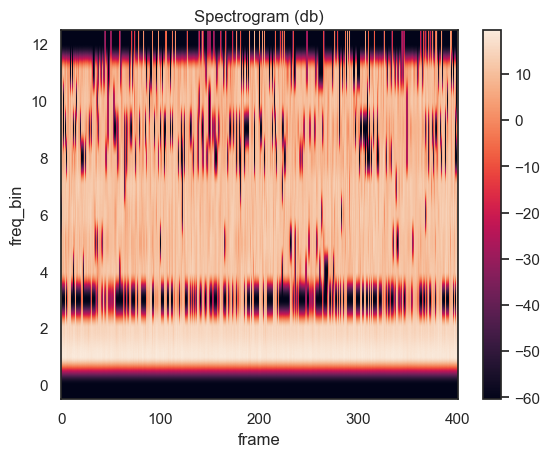

In [227]:
plot_spectrogram(mfcc_test[7])

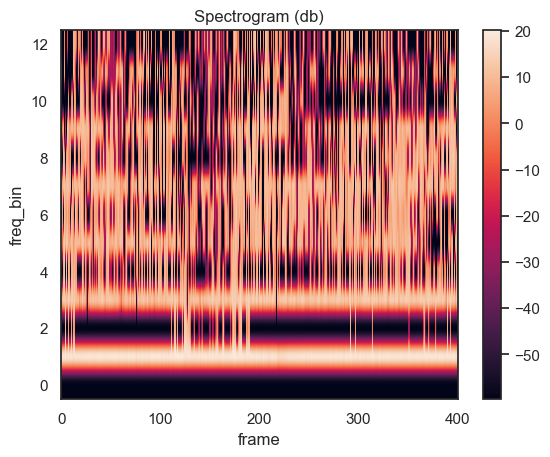

In [228]:
plot_spectrogram(mfcc_test_normal[7])

### Apply to full list of paths for clustering

In [229]:
from ipywidgets import IntProgress
from IPython.display import display
import time

In [230]:
mfcc = test_data['filename'].apply(lambda x: mfcc_extract(x))
lfcc = test_data['filename'].apply(lambda x: lfcc_extract(x))

In [231]:
len(mfcc[1])

8

In [232]:
len(mfcc[1][1])

13

## Pitch

In [233]:
import torchaudio.functional as F
import torch

def wave_sr_extract(filename):
    y, sr = torchaudio.load(filename, normalize=True)
    return y, sr

def pitch_extract(w,sr):
    pitch = F.detect_pitch_frequency(w, sr)
    return pitch

def df_pitch_extract(filename):
    w, sr = torchaudio.load(filename, normalize=True)
    pitch = F.detect_pitch_frequency(w, sr)
    return pitch.numpy()


def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


In [234]:
w1, sr1 = wave_sr_extract(df.filename[2])
w2, sr2 = wave_sr_extract(df.filename[800])
pitch1 = pitch_extract(w1,sr1)
pitch2 = pitch_extract(w2,sr2)

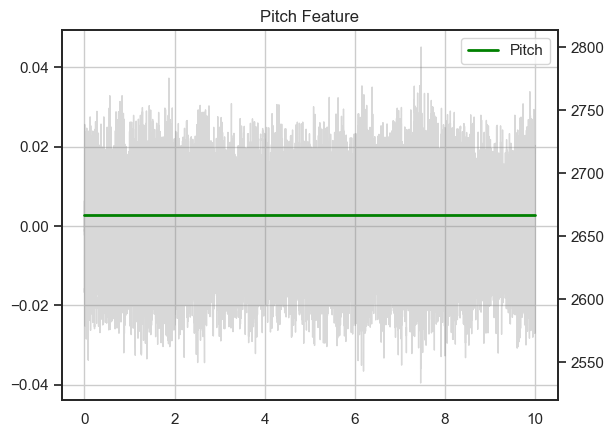

In [235]:
plot_pitch(w1, sr1, pitch1)

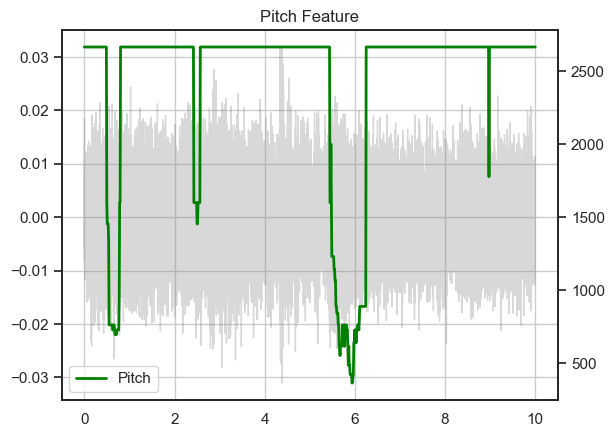

In [236]:
plot_pitch(w2, sr2, pitch2)

In [237]:
pitch = test_data['filename'].apply(df_pitch_extract)


In [238]:
n=len(pitch)
mean_pitch = []
for k in range(n):
    d=np.diff(pitch[k])
    mean_pitch.append(np.mean(d))




In [239]:
len(mean_pitch)

1418

## Get mean and sd of fcc

In [240]:
mfcc[1].shape

(8, 13, 401)

In [241]:
f = len(mfcc)
t = 8 # 8 ?
mel_n =13
#save in vectors
stddev_mfcc = []
stddev_lfcc = []
mean_mfcc = []
mean_lfcc = []

for k in range(f):
    m=mfcc[k]
    l=lfcc[k]
    # Get the mean and standard deviation
    mean_mfcc.append(np.mean(m, axis=0))
    mean_lfcc.append(np.mean(l, axis=0))

    stddev_mfcc.append(np.std(m, axis=0))
    stddev_lfcc.append(np.std(l, axis=0))

In [253]:
std_mfcc=pd.Series(stddev_mfcc).apply(np.mean)
std_lfcc=pd.Series(stddev_lfcc).apply(np.mean)

In [244]:
test_data = test_data[['filename', 'label', 'type']]
test_data['mfcc'] = mean_mfcc
exploded_df = test_data.explode(['mfcc'])
exploded_df['mfcc'] = exploded_df['mfcc'].apply(np.mean)
exploded_df.head()

,filename,label,type,mfcc
0,data/fan/id_00/abnormal/00000000.wav,1,fan,-255.629364
0,data/fan/id_00/abnormal/00000000.wav,1,fan,76.591225
0,data/fan/id_00/abnormal/00000000.wav,1,fan,31.368464
0,data/fan/id_00/abnormal/00000000.wav,1,fan,1.276155
0,data/fan/id_00/abnormal/00000000.wav,1,fan,15.021034


In [246]:
test_data1 = test_data[[ 'filename', 'label', 'type']]
test_data1['lfcc'] = mean_lfcc


exploded_df1 = test_data1.explode(['lfcc'])
exploded_df1['lfcc'] = exploded_df1['lfcc'].apply(np.mean)
exploded_df1.head()

,filename,label,type,lfcc
0,data/fan/id_00/abnormal/00000000.wav,1,fan,-312.288605
0,data/fan/id_00/abnormal/00000000.wav,1,fan,65.745361
0,data/fan/id_00/abnormal/00000000.wav,1,fan,48.066261
0,data/fan/id_00/abnormal/00000000.wav,1,fan,27.892149
0,data/fan/id_00/abnormal/00000000.wav,1,fan,12.797047


In [247]:
mfcc_label = []
lfcc_label = []
for i, number in enumerate(range(1, 14), start=1):
   mfcc_label.append(f"mfcc_{number}")
   lfcc_label.append(f"lfcc_{number}")


In [248]:
# exploded_df['lfcc_label'] = lfcc_label*len(test_data)
exploded_df['mfcc_label'] = mfcc_label*len(test_data)
exploded_df.head()

,filename,label,type,mfcc,mfcc_label
0,data/fan/id_00/abnormal/00000000.wav,1,fan,-255.629364,mfcc_1
0,data/fan/id_00/abnormal/00000000.wav,1,fan,76.591225,mfcc_2
0,data/fan/id_00/abnormal/00000000.wav,1,fan,31.368464,mfcc_3
0,data/fan/id_00/abnormal/00000000.wav,1,fan,1.276155,mfcc_4
0,data/fan/id_00/abnormal/00000000.wav,1,fan,15.021034,mfcc_5


In [249]:
exploded_df1['lfcc_label'] = lfcc_label*len(test_data1)
exploded_df1.head()

,filename,label,type,lfcc,lfcc_label
0,data/fan/id_00/abnormal/00000000.wav,1,fan,-312.288605,lfcc_1
0,data/fan/id_00/abnormal/00000000.wav,1,fan,65.745361,lfcc_2
0,data/fan/id_00/abnormal/00000000.wav,1,fan,48.066261,lfcc_3
0,data/fan/id_00/abnormal/00000000.wav,1,fan,27.892149,lfcc_4
0,data/fan/id_00/abnormal/00000000.wav,1,fan,12.797047,lfcc_5


In [254]:
df_wide=pd.pivot(exploded_df, columns = ['mfcc_label'], values='mfcc')#Reshape from long to wide
df_wide

df_wide1=pd.pivot(exploded_df1, columns = ['lfcc_label'], values='lfcc')#Reshape from long to wide
df_wide1

test_wide = pd.concat([df_wide, df_wide1], axis=1)
test_wide['pitch'] = mean_pitch
test_wide['std_lfcc'] = std_lfcc
test_wide['std_mfcc'] = std_mfcc

In [255]:
test_data = test_data[['filename', 'label', 'type']]
test_df = pd.concat([test_wide, test_data], axis=1)

In [256]:
test_data2 = test_data[['filename', 'label', 'type']]
test_data2['mfcc'] = mean_mfcc
test_data2['pitch'] = pitch



In [257]:
test_df.describe()

,mfcc_1,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,...,lfcc_4,lfcc_5,lfcc_6,lfcc_7,lfcc_8,lfcc_9,pitch,std_lfcc,std_mfcc,label
count,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,...,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1418.000000,1.418000e+03,1418.000000,1418.000000,1418.000000
mean,-249.909271,3.110629,1.910009,2.076366,-0.816169,63.436691,10.067674,15.044910,3.841437,6.667199,...,20.363548,9.772152,10.886909,5.373595,7.603007,3.070694,9.034420e-02,4.360169,4.058214,0.287024
std,18.885357,2.506315,3.185100,2.695773,3.720258,18.485855,9.688083,10.321528,4.270467,4.040427,...,4.203228,3.121138,3.098447,2.945381,2.089860,2.457820,7.437953e-01,0.347813,0.316657,0.452532
min,-315.728149,-8.573662,-10.890771,-9.862829,-13.445092,-11.571959,-34.101410,-7.241332,-9.879109,-5.103736,...,-0.922808,-4.758397,0.687102,-4.428522,-3.017255,-8.508046,-2.399435e+00,3.793707,3.462611,0.000000
25%,-259.266762,1.833189,0.318074,1.043825,-3.140785,53.487901,2.500367,5.293859,0.084229,3.866277,...,19.396800,8.438112,8.862586,3.280601,6.258508,1.652917,-2.907544e-08,4.142176,3.797928,0.000000
50%,-250.410271,3.027063,1.583026,2.134943,-0.083435,67.573456,10.154642,19.112720,4.303190,6.551175,...,20.975084,9.928273,10.741560,5.825433,7.827868,3.175009,0.000000e+00,4.340089,4.069519,0.000000
75%,-242.781418,4.350353,3.287823,3.672871,1.245670,76.565624,16.297266,22.625047,6.549076,8.576309,...,21.911686,11.405423,12.228452,6.806135,8.779585,4.302653,3.263367e-01,4.475000,4.257049,1.000000
max,-189.647049,15.705408,13.867368,11.228910,10.416319,112.809273,41.500446,37.418961,19.107550,20.689224,...,33.759548,21.795816,32.424297,27.051249,19.745119,11.720374,2.585756e+00,5.699353,5.030947,1.000000


In [258]:
test_df['label'].value_counts()

0    1011
1     407
Name: label, dtype: int64

# IF

In [346]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest


# X_name = ['mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_2',
#          'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
#          'pitch', 'std_mfcc']


X_name = ['lfcc_10', 'lfcc_11', 'lfcc_12', 'lfcc_13', 'lfcc_2',
         'lfcc_3', 'lfcc_4', 'lfcc_5', 'lfcc_6', 'lfcc_7', 'lfcc_8', 'lfcc_9',
         'pitch', 'std_lfcc']

In [347]:
model_IF = IsolationForest(random_state=42)

In [348]:
model_IF.fit(test_df[X_name])

IsolationForest(random_state=42)

In [349]:
test_df['anomaly_scores'] = model_IF.decision_function(test_df[X_name])
test_df['anomaly'] = model_IF.predict(test_df[X_name])
test_df['anomaly']  = test_df['anomaly'] .replace([-1, 1], [1, 0])

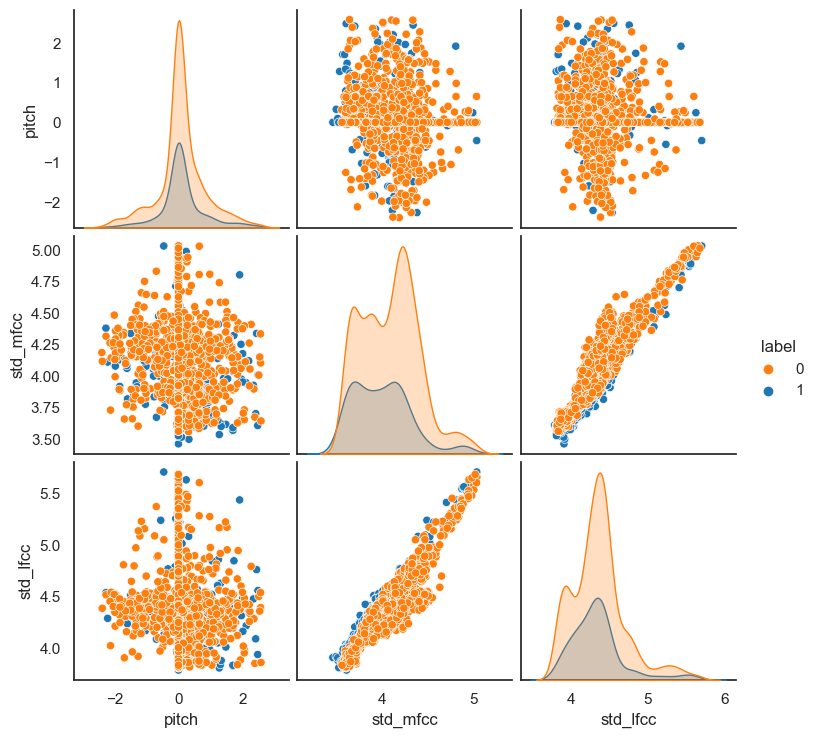

In [350]:
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(test_df, vars=['pitch','std_mfcc', 'std_lfcc'], hue='label', palette=palette)

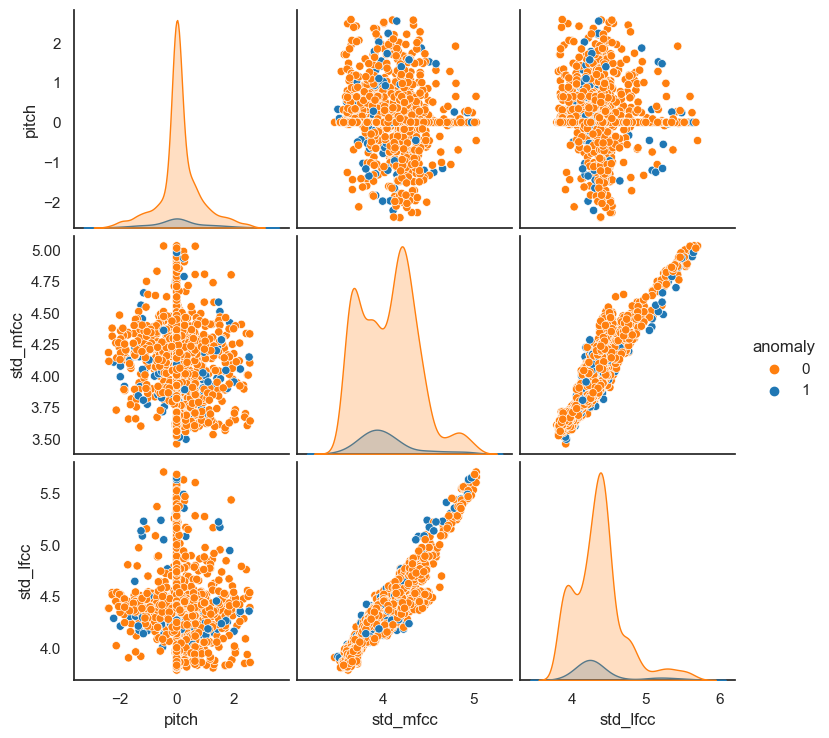

In [351]:
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(test_df, vars=['pitch','std_mfcc', 'std_lfcc'], hue='anomaly', palette=palette)

In [352]:
def outlier_plot(data, outlier_method_name, x_var, y_var,
                 xaxis_limits=[-100,100], yaxis_limits=[-100,100]):

    print(f'Outlier Method: {outlier_method_name}')

    # Create a dynamic title based on the method
    method = f'{outlier_method_name}_anomaly'

    # Print out key statistics
    print(f"Number of anomalous values {len(data[data['anomaly']== 1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 0])}")
    print(f'Total Number of Values: {len(data)}')

    # Create the chart using seaborn
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1 ,0])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    return g



Outlier Method: Isolation Forest
Number of anomalous values 123
Number of non anomalous values  1295
Total Number of Values: 1418


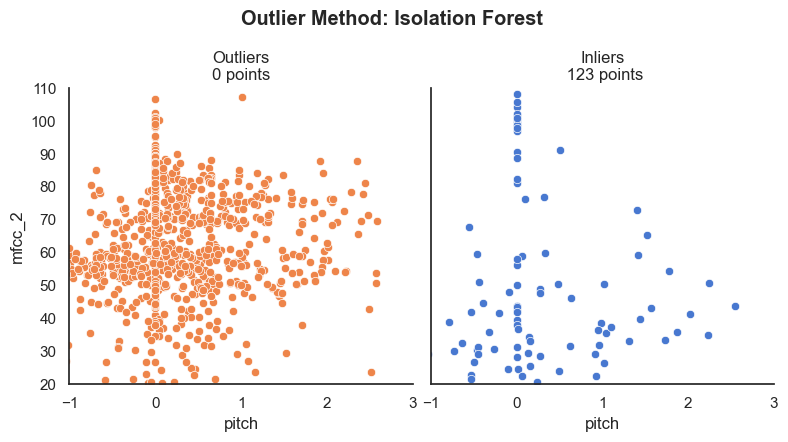

In [353]:
outlier_plot(test_df, 'Isolation Forest', 'pitch', 'mfcc_2', [-1, 3], [20, 110]);

# IF + PCA

### mfcc + pitch

In [366]:
# Import libraries
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
# X=test_df[['mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_2',
# 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
# 'pitch', 'std_mfcc']]
X = test_df[['lfcc_10', 'lfcc_11', 'lfcc_12', 'lfcc_13', 'lfcc_2', 'lfcc_3', 'lfcc_4', 'lfcc_5', 'lfcc_6', 'lfcc_7', 'lfcc_8', 'lfcc_9', 'pitch', 'std_lfcc']]
X2 = test_data2['mfcc']
scaler = MinMaxScaler()
sample_scaled = scaler.fit_transform(X)


In [367]:
np.cumsum(pca.explained_variance_ratio_)

array([0.33895808, 0.46484115, 0.57090484, 0.65256949, 0.72695548,
       0.78907775, 0.84671399, 0.89974073, 0.93008574, 0.95196514])

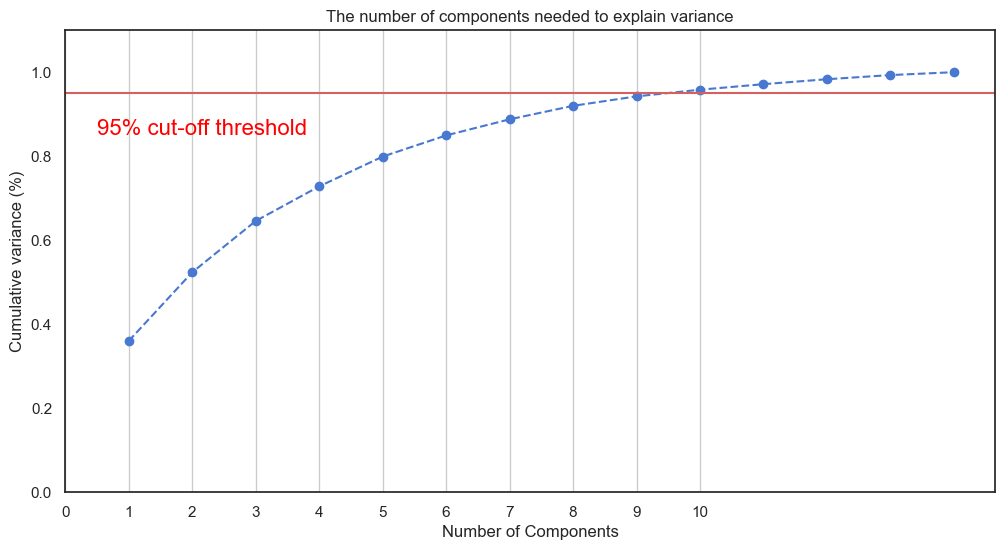

In [368]:
pca = PCA().fit(sample_scaled)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 15, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [372]:
# Define dimensions = 2
pca = PCA(n_components=9)

# Conduct the PCA
principal_comp = pca.fit_transform(sample_scaled)

In [373]:
# # Convert to dataframe
# pca_df = pd.DataFrame(data = principal_comp, columns = ['principal_component_1', 'principal_component_2'])
# pca_df
# Convert to dataframe
pca_df = pd.DataFrame(data = principal_comp)
pca_df

,0,1,2,3,4,5,6,7,8
0,0.224964,-0.313358,-0.297286,0.135685,0.073411,-0.124586,-0.003914,-0.065480,0.080321
1,0.325493,-0.254571,-0.292788,0.018237,0.041363,-0.074500,0.063407,-0.074444,0.020155
2,-0.005756,-0.386583,-0.296201,0.037879,0.307711,-0.037090,-0.043071,-0.039919,-0.051708
3,0.344017,-0.216603,-0.320871,-0.131346,0.072269,-0.067369,0.081250,-0.073241,0.040966
4,-0.497342,-0.079686,-0.229680,-0.072150,-0.005046,0.057221,0.055580,-0.023031,0.103670
...,...,...,...,...,...,...,...,...,...
1413,0.544901,0.034225,-0.043910,0.106292,-0.098304,-0.106326,0.012208,0.057915,0.051665
1414,-0.081996,0.503867,0.410631,0.007766,0.323659,0.079004,-0.117076,-0.162223,-0.105841
1415,-0.223920,0.157841,-0.195038,-0.055018,-0.048227,0.073167,-0.034433,0.000147,-0.007652
1416,-0.232468,-0.500738,0.397194,0.012355,-0.088818,-0.002868,0.037726,0.010239,0.040656


In [374]:
# Train the model
isf = IsolationForest()
isf.fit(pca_df)
# Predictions
predictions = isf.predict(pca_df)
# Extract scores
pca_df["iso_forest_scores"] = isf.decision_function(pca_df)
# Extract predictions
pca_df["iso_forest_outliers"] = predictions

pca_df["outliers"] = test_df['label']
# Describe the dataframe
pca_df.describe()

,0,1,2,3,4,5,6,7,8,iso_forest_scores,iso_forest_outliers,outliers
count,1.418000e+03,1.418000e+03,1.418000e+03,1.418000e+03,1.418000e+03,1.418000e+03,1.418000e+03,1.418000e+03,1.418000e+03,1418.000000,1418.000000,1418.000000
mean,-3.797307e-18,3.521317e-17,-2.910616e-17,-5.204660e-17,-2.242418e-17,-1.292357e-17,1.595750e-17,-1.189962e-17,-2.447942e-18,0.075793,0.791255,0.287024
std,3.086580e-01,2.080106e-01,1.798935e-01,1.476633e-01,1.370834e-01,1.156024e-01,1.006558e-01,9.225254e-02,7.726256e-02,0.056413,0.611702,0.452532
min,-6.130344e-01,-5.874675e-01,-4.003473e-01,-4.730561e-01,-3.780859e-01,-3.553469e-01,-5.072167e-01,-5.236051e-01,-4.752249e-01,-0.165298,-1.000000,0.000000
25%,-2.354783e-01,-1.010034e-01,-1.191625e-01,-6.301845e-02,-8.533120e-02,-5.808126e-02,-5.303023e-02,-3.160580e-02,-3.570976e-02,0.052690,1.000000,0.000000
50%,-1.349778e-01,5.838896e-03,-3.000089e-02,-2.948065e-02,-3.235513e-02,2.150744e-02,-1.066920e-02,1.270049e-03,-4.940232e-03,0.088770,1.000000,0.000000
75%,2.583561e-01,1.363141e-01,7.201599e-02,6.498770e-02,6.717188e-02,6.528639e-02,4.654043e-02,3.001247e-02,2.680739e-02,0.115674,1.000000,1.000000
max,6.898712e-01,6.497594e-01,8.369912e-01,5.595572e-01,6.994755e-01,5.244219e-01,7.195354e-01,6.586297e-01,4.791009e-01,0.146912,1.000000,1.000000


In [375]:
# Replace "-1" with "Yes" and "1" with "No"
pca_df['iso_forest_outliers'] = pca_df['iso_forest_outliers'].replace([-1, 1], [1, 0])
# Print the first 5 firms
pca_df.head()

,0,1,2,3,4,5,6,7,8,iso_forest_scores,iso_forest_outliers,outliers
0,0.224964,-0.313358,-0.297286,0.135685,0.073411,-0.124586,-0.003914,-0.065480,0.080321,0.036540,0,1
1,0.325493,-0.254571,-0.292788,0.018237,0.041363,-0.074500,0.063407,-0.074444,0.020155,0.060428,0,1
2,-0.005756,-0.386583,-0.296201,0.037879,0.307711,-0.037090,-0.043071,-0.039919,-0.051708,0.026278,0,1
3,0.344017,-0.216603,-0.320871,-0.131346,0.072269,-0.067369,0.081250,-0.073241,0.040966,0.047975,0,1
4,-0.497342,-0.079686,-0.229680,-0.072150,-0.005046,0.057221,0.055580,-0.023031,0.103670,0.080778,0,1


In [378]:
# Create a function to plot firms on the 2-dimensional space
def plot_firms (dataframe, title, color = None):
    """ Plot firms on the 2-dimensional space """

    # Generate a scatter plot
    fig = px.scatter(pca_df, x=7, y=8, title=title, color=color)

    return(fig)
# Need to import renderers to view the plots on GitHub
import plotly.io as pio

plot_firms(dataframe=pca_df, title="Figure 2: Normal  vs. Outlier", color='iso_forest_outliers')

In [379]:
plot_firms(dataframe=pca_df, title="Figure 2: Normal  vs. Outlier", color='outliers')

In [380]:
from sklearn.metrics import accuracy_score
y_pred = pca_df["iso_forest_outliers"]
y_true = pca_df["outliers"]
accuracy_score(y_true, y_pred)

0.6833568406205924